In [22]:
import pandas as pd
import datetime as dt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

import imageio
import glob
import os

In [4]:
import xarray as xr

# File paths
files = [
    "/g/data/ia39/aus-ref-clim-data-nci/frogs/data/1DD_V1/IMERG_V07B_FC/IMERG_V07B_FC.1DD.2020.nc",
    "/g/data/ia39/aus-ref-clim-data-nci/frogs/data/1DD_V1/IMERG_V07B_FC/IMERG_V07B_FC.1DD.2021.nc"
]

ds = xr.open_mfdataset(files, combine='by_coords')


In [5]:
print(ds)

<xarray.Dataset> Size: 189MB
Dimensions:  (time: 731, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-01-01T12:00:00 ... 2021-12-31T12:...
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    rain     (time, lat, lon) float32 189MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                ACDD-1.3, CF-1.8
    title:                      Frogs daily 1 degree x 1 degree gridded preci...
    summary:                    The Frequent Rainfall Observations on GridS (...
    references:                 See https://www.earth-syst-sci-data.net/11/10...
    source:                     Gridded Daily Accumulated Rainfall derived fr...
    institution:                NASA/LEGOS/IPSL
    ...                         ...
    platform:                   GCMD:Earth Observation Satellites
    instruments

In [6]:
ds.time

<xarray.DataArray 'time' (time: 731)> Size: 6kB
array(['2020-01-01T12:00:00.000000000', '2020-01-02T12:00:00.000000000',
       '2020-01-03T12:00:00.000000000', ..., '2021-12-29T12:00:00.000000000',
       '2021-12-30T12:00:00.000000000', '2021-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-01-01T12:00:00 ... 2021-12-31T12:...
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    comment:        The time values of the grid, following the standard CF ca...

In [7]:
ds_subset = ds.sel(time=slice("2020-01-20T00:00:00", "2021-04-01T00:00:00"))


In [9]:
print(ds_subset)


<xarray.Dataset> Size: 113MB
Dimensions:  (time: 437, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-20T12:00:00 ... 2021-03-31T12:...
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    rain     (time, lat, lon) float32 113MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                ACDD-1.3, CF-1.8
    title:                      Frogs daily 1 degree x 1 degree gridded preci...
    summary:                    The Frequent Rainfall Observations on GridS (...
    references:                 See https://www.earth-syst-sci-data.net/11/10...
    source:                     Gridded Daily Accumulated Rainfall derived fr...
    institution:                NASA/LEGOS/IPSL
    ...                         ...
    platform:                   GCMD:Earth Observation Satellites
    instruments

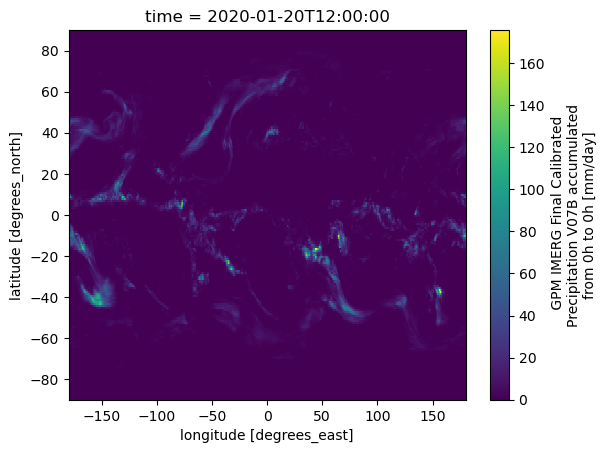

In [11]:
ds_subset.rain[0,:,:].plot()

In [12]:
rain_mc = ds_subset.rain.sel(
    lon=slice(100, 149),
    lat=slice(-10, 10)
)


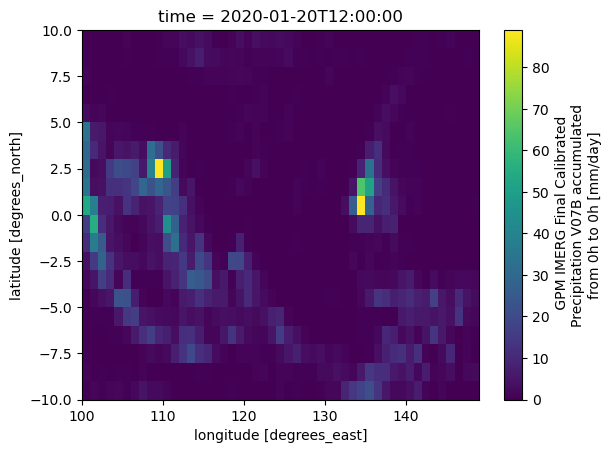

In [14]:
rain_mc[0,:,:].plot()

In [16]:
print(rain_mc)

<xarray.DataArray 'rain' (time: 437, lat: 20, lon: 49)> Size: 2MB
dask.array<getitem, shape=(437, 20, 49), dtype=float32, chunksize=(1, 20, 49), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-20T12:00:00 ... 2021-03-31T12:...
  * lon      (lon) float32 196B 100.5 101.5 102.5 103.5 ... 146.5 147.5 148.5
  * lat      (lat) float32 80B -9.5 -8.5 -7.5 -6.5 -5.5 ... 5.5 6.5 7.5 8.5 9.5
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:       GPM IMERG Final Calibrated Precipitation V07B accumulate...
    units:          mm/day
    comment:        This daily precipitation is calculated from the half hour...


In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

output_dir = "/scratch/up6/gs5098/hackathon2025/hackathon-2025-australia-node/hk25-AusNode-DOCmeso/get_metrics/Greeshma/"
os.makedirs(output_dir, exist_ok=True)

rain_monthly = rain_mc.resample(time="1M").mean().compute()

vmin = 0
vmax = 43

for i in range(rain_monthly.time.size):
    month = rain_monthly.isel(time=i)
    date_str = np.datetime_as_string(month.time.values, unit='M')  # e.g., '2020-01'

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())

    month.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'label': 'Monthly Mean Precipitation (mm/day)'}
    )

    ax.coastlines()
    ax.set_title(f"Monthly Mean Precipitation: {date_str}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Save plot
    filename = os.path.join(output_dir, f"monthly_mean_{date_str}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close(fig)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [27]:
import imageio.v2 as imageio
from natsort import natsorted  # pip install natsort